<a href="https://colab.research.google.com/github/nhuang37/2018/blob/master/common_3_1_concat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import spacy
import string
from collections import Counter
import numpy as np
import torch
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle as pkl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
snli_train=pd.read_csv('drive/My Drive/NLP_HW1_data/snli_train.tsv', sep='\t') #added gdrive path

In [0]:
# Define tokenizer
# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize(sent):
  tokens = tokenizer(sent)
  return [token.text.lower() for token in tokens if (token.text not in punctuations)]

def tokenize_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(sample)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

In [0]:
# Load pickles for sentence tokens for train set
snli_train_sentence1 = pkl.load(open('drive/My Drive/NLP_HW1_data/snli_train_sentence1.p', 'rb'))
snli_train_sentence1_tokens, snli_train_sentence1_all_tokens = snli_train_sentence1
snli_train_sentence2 = pkl.load(open('drive/My Drive/NLP_HW1_data/sentence2_tokens.p', 'rb'))
snli_train_sentence2_tokens, snli_train_sentence2_all_tokens = snli_train_sentence2

In [0]:
# Build vocabulary
snli_train_all_tokens = snli_train_sentence1_all_tokens + snli_train_sentence2_all_tokens

max_vocab_size = 10000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(snli_train_all_tokens)

In [0]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

snli_train_sentence1_indices = token2index_dataset(snli_train_sentence1_tokens)
snli_train_sentence2_indices = token2index_dataset(snli_train_sentence2_tokens)

In [0]:
# Process validation set

snli_val=pd.read_csv('drive/My Drive/NLP_HW1_data/snli_val.tsv', sep='\t') #added gdrive path
snli_val_sentence1 = pkl.load(open('drive/My Drive/NLP_HW1_data/snli_val_sentence1.p', 'rb'))
snli_val_sentence2 = pkl.load(open('drive/My Drive/NLP_HW1_data/snli_val_sentence2.p', 'rb'))
snli_val_sentence1_tokens, snli_val_sentence1_all_tokens = snli_val_sentence1
snli_val_sentence2_tokens, snli_val_sentence2_all_tokens = snli_val_sentence2
snli_val_sentence1_indices = token2index_dataset(snli_val_sentence1_tokens)
snli_val_sentence2_indices = token2index_dataset(snli_val_sentence2_tokens)

In [0]:
# snli_val_sentence1 = tokenize_dataset(snli_val[:]['sentence1'])
# snli_val_sentence2 = tokenize_dataset(snli_val[:]['sentence2'])
# pkl.dump(snli_val_sentence1, open('snli_val_sentence1.p', 'wb'))
# pkl.dump(snli_val_sentence2, open('snli_val_sentence2.p', 'wb'))

In [0]:
# Dataset
BATCH_SIZE = 32
MAX_SENTENCE_LENGTH = 200

def label_to_cat(label):
    if label == 'entailment':
        return 0
    if label == 'neutral':
        return 1
    if label == 'contradiction':
        return 2

    
def snli_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    sentence1_list = []
    sentence2_list = []
    label_list = []
    sentence1_length_list = []
    sentence2_length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        sentence1_length_list.append(datum[1]['sentence1'])
        sentence2_length_list.append(datum[1]['sentence2'])
    # padding
    for datum in batch:
        padded_vec1 = np.pad(np.array(datum[0]['sentence1']), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1]['sentence1'])), 
                                mode="constant", constant_values=0)
        sentence1_list.append(padded_vec1)
        padded_vec2 = np.pad(np.array(datum[0]['sentence2']), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1]['sentence2'])), 
                                mode="constant", constant_values=0)
        sentence2_list.append(padded_vec2)
    return [{
        'sentence1': torch.from_numpy(np.array(sentence1_list)),
        'sentence2': torch.from_numpy(np.array(sentence2_list))
    }, {
        'sentence1': torch.LongTensor(sentence1_length_list),
        'sentence2': torch.LongTensor(sentence2_length_list)
    }, torch.LongTensor([label_to_cat(l) for l in label_list])]


class SNLIDataset(Dataset):
    def __init__(self, sentence1_list, sentence2_list, label_list):
        """
        @param sentence1_list: list of sentence1 tokens 
        @param sentence2_list: list of sentence2 tokens 
        @param label_list: list of labels 
        """
        self.sentence1_list = sentence1_list
        self.sentence2_list = sentence2_list
        self.label_list = label_list
        assert (len(self.sentence1_list) == len(self.label_list))
        assert (len(self.sentence2_list) == len(self.label_list))

    def __len__(self):
        return len(self.sentence1_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        sentence1_token_idx = self.sentence1_list[key][:MAX_SENTENCE_LENGTH]
        sentence2_token_idx = self.sentence2_list[key][:MAX_SENTENCE_LENGTH]
        label = self.label_list[key]
        return [{'sentence1': sentence1_token_idx, 'sentence2': sentence2_token_idx}, 
                {'sentence1': len(sentence1_token_idx), 'sentence2': len(sentence2_token_idx)}, 
                 label]

    
train_dataset = SNLIDataset(snli_train_sentence1_indices, snli_train_sentence2_indices, snli_train[:]['label'])
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=snli_collate_func,
                                           shuffle=True)
val_dataset = SNLIDataset(snli_val_sentence1_indices, snli_val_sentence2_indices, snli_val[:]['label'])
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=snli_collate_func,
                                           shuffle=True)

In [0]:
from torch.optim.lr_scheduler import StepLR

In [0]:
# Function for testing the model
def test_model(loader, model, criterion, device):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    total_loss = 0
    num_batches = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    for data, lengths, labels in loader:
        num_batches += 1
        data_batch, length_batch, label_batch = data, lengths, labels

        # Send inputs to the correct device
        data_batch = {k: v.to(device) for k, v in data_batch.items()}
        length_batch = {k: v.to(device) for k, v in length_batch.items()}
        label_batch = label_batch.to(device)

        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        total_loss += criterion(outputs, label_batch).detach()
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted).to(device)).sum().item()
    return (100 * correct / total), total_loss / num_batches

In [0]:
def run_model(model, 
              optimizer,
              num_epochs=10, 
              test_model=test_model,
              criterion=nn.NLLLoss() , #torch.nn.CrossEntropyLoss(),
              train_loader=train_loader,
              val_loader=val_loader,
              scheduler=None,
              device=torch.device("cpu")):
    if scheduler is None:
        scheduler = StepLR(optimizer, step_size=1, gamma=1)
    train_acc_history, train_loss_history, val_acc_history, val_loss_history = [], [], [], []
    for epoch in range(num_epochs):
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            
            # Send inputs to the correct device
            data_batch = {k: v.to(device) for k, v in data_batch.items()}
            length_batch = {k: v.to(device) for k, v in length_batch.items()}
            label_batch = label_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                val_acc, val_loss = test_model(val_loader, model, criterion, device)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, Validation Loss: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc, val_loss))
        # Calculate train accuracy and loss per each epoch
        train_acc, train_loss = test_model(train_loader, model, criterion, device)
        val_acc, val_loss = test_model(val_loader, model, criterion, device)
        print('Epoch: [{}/{}], Validation Acc: {}, Validation Loss: {}'.format( 
            epoch+1, num_epochs, val_acc, val_loss))
        print('Epoch: [{}/{}], Train Acc: {}, Train Loss:{}'.format(
            epoch+1, num_epochs, train_acc, train_loss))
        train_acc_history.append(train_acc)
        train_loss_history.append(train_loss)
        val_acc_history.append(val_acc)
        val_loss_history.append(val_loss)
        scheduler.step()
    torch.save(model.state_dict(), 'model_test.pt')
    return train_acc_history, train_loss_history, val_acc_history, val_loss_history

In [0]:
# Example code to run NN model: sum prem & hypo
class TwolayerNN(nn.Module):
    """
    TwolayerNN classification model using 2 hidden layers 
    """
    def __init__(self, vocab_size, emb_dim, method): #additional param to change the method
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(TwolayerNN, self).__init__()
        # pay attention to padding_idx 
        self.method = method
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0) 
        if self.method == "concat":
          self.fc1 = nn.Linear(emb_dim * 2, 200) #concat case: can change the number of neurons
        else:
          self.fc1 = nn.Linear(emb_dim, 200) #sum / product case
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 3) #output classify into 3 classes
    
    def forward(self, data, length):
        """
        @param data: dictionary
        @param data['sentence1']: data class matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        #create embeddings for premises: 
        prem_embed = self.embed(data['sentence1'].to(torch.long)) #sentence 1 embeddings, return 32 (batch size) x 200 (max_length) x 100 (word embedding dimension)
        prem_embed = torch.sum(prem_embed, dim=1) #return 32 x 100
        prem_embed /= length['sentence1'].view(length['sentence1'].size()[0],1).expand_as(prem_embed).float() #divide by the actual number of words in each row

        #create embeddings for hypothesis: 
        hypo_embed = self.embed(data['sentence2'].to(torch.long))
        hypo_embed = torch.sum(hypo_embed, dim=1) #return 32 x 100
        hypo_embed /= length['sentence2'].view(length['sentence2'].size()[0],1).expand_as(hypo_embed).float() #divide by the actual number of words in each row

        #concatenation of prem & hypo
        if self.method == "concat":
          out = torch.cat((prem_embed, hypo_embed), 1) #return 32 x 200
        #sum of prem & hypo
        elif self.method == "sum":
          out = prem_embed.add(hypo_embed) #return 32 x 100
        #element-wise multiplication prem & hypo
        else:
          out = prem_embed * hypo_embed #return 32 x 100

        # return logits
        out = F.relu(self.fc1(out.float()))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return F.log_softmax(out)


def run_nn_model():
    emb_dim = 100
    model = TwolayerNN(len(id2token), emb_dim,"product")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    learning_rate = 0.01
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_acc_history, train_loss_history, val_acc_history, val_loss_history = run_model(model, optimizer, device=device)
    return train_acc_history, train_loss_history, val_acc_history, val_loss_history 

In [15]:
train_acc_history, train_loss_history, val_acc_history, val_loss_history = run_nn_model()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: [1/10], Step: [101/3125], Validation Acc: 36.4, Validation Loss: -0.3402162492275238
Epoch: [1/10], Step: [201/3125], Validation Acc: 45.5, Validation Loss: -0.3689901530742645
Epoch: [1/10], Step: [301/3125], Validation Acc: 46.6, Validation Loss: -0.36872005462646484
Epoch: [1/10], Step: [401/3125], Validation Acc: 49.8, Validation Loss: -0.3864924907684326
Epoch: [1/10], Step: [501/3125], Validation Acc: 47.6, Validation Loss: -0.41374510526657104
Epoch: [1/10], Step: [601/3125], Validation Acc: 50.8, Validation Loss: -0.42520156502723694
Epoch: [1/10], Step: [701/3125], Validation Acc: 52.6, Validation Loss: -0.44160956144332886
Epoch: [1/10], Step: [801/3125], Validation Acc: 52.2, Validation Loss: -0.4125920534133911
Epoch: [1/10], Step: [901/3125], Validation Acc: 54.9, Validation Loss: -0.43046244978904724
Epoch: [1/10], Step: [1001/3125], Validation Acc: 57.8, Validation Loss: -0.44201967120170593
Epoch: [1/10], Step: [1101/3125], Validation Acc: 57.7, Validation Loss: 

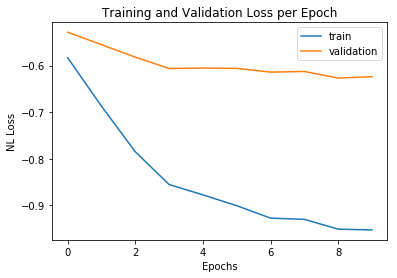

In [28]:
#plot NN loss
plt.plot(train_loss_history, label="train")
plt.plot( val_loss_history, label="validation")
plt.xlabel("Epochs")
plt.ylabel("NL Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend(loc="best")

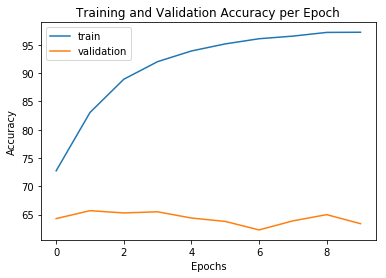

In [29]:
#plot NN accuracies
plt.plot(train_acc_history, label="train")
plt.plot(val_acc_history, label="validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy per Epoch")
plt.legend(loc="best")

In [0]:
# Example code running Logistic Regression model.
class LogisticRegression(nn.Module):
    """
    TwolayerNN classification model using 2 hidden layers 
    """
    def __init__(self, vocab_size, emb_dim, method):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        @param method: method to interact prem & hypo
        """
        
        super(LogisticRegression, self).__init__()
        # pay attention to padding_idx 
        self.method = method
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0) 
        if self.method == "concat":
          self.linear = nn.Linear(emb_dim * 2, 3) #concat cases
        else:
          self.linear = nn.Linear(emb_dim, 3) #sum / product case
        self.init_weights()
        
    def forward(self, data, length):
        """
        @param data: dictionary
        @param data['sentence1']: data class matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        #create embeddings for premises: 
        prem_embed = self.embed(data['sentence1'].to(torch.long)) #sentence 1 embeddings, return 32 (batch size) x 200 (max_length) x 100 (word embedding dimension)
        prem_embed = torch.sum(prem_embed, dim=1) #return 32 x 100
        prem_embed /= length['sentence1'].view(length['sentence1'].size()[0],1).expand_as(prem_embed).float() #divide by the actual number of words in each row

        #create embeddings for hypothesis: 
        hypo_embed = self.embed(data['sentence2'].to(torch.long))
        hypo_embed = torch.sum(hypo_embed, dim=1) #return 32 x 100
        hypo_embed /= length['sentence2'].view(length['sentence2'].size()[0],1).expand_as(hypo_embed).float() #divide by the actual number of words in each row
        
        #concatenation of prem & hypo
        if self.method == "concat":
          out = torch.cat((prem_embed, hypo_embed), 1) #return 32 x 200
        #sum of prem & hypo
        elif self.method == "sum":
          out = prem_embed.add(hypo_embed) #return 32 x 100
        #element-wise multiplication prem & hypo
        else:
          out = prem_embed * hypo_embed #return 32 x 100

        # return logits
        out = self.linear(out.float())
        return F.log_softmax(out, dim=1)
        
    def init_weights(self):
        # Use some specific initialization schemes
        nn.init.xavier_normal_(self.linear.weight)
        nn.init.uniform_(self.linear.bias)



def run_logreg_model():
    emb_dim = 100
    model = LogisticRegression(len(id2token), emb_dim, "sum")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.NLLLoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    train_acc_history, train_loss_history, val_acc_history, val_loss_history = run_model(model, optimizer, device=device)
    return train_acc_history, train_loss_history, val_acc_history, val_loss_history 
 


In [23]:
torch.cuda.is_available()

True

In [24]:
train_acc_history, train_loss_history, val_acc_history, val_loss_history = run_logreg_model()

Epoch: [1/10], Step: [101/3125], Validation Acc: 36.6, Validation Loss: -0.3632601201534271
Epoch: [1/10], Step: [201/3125], Validation Acc: 36.2, Validation Loss: -0.36164647340774536
Epoch: [1/10], Step: [301/3125], Validation Acc: 43.5, Validation Loss: -0.41496914625167847
Epoch: [1/10], Step: [401/3125], Validation Acc: 43.2, Validation Loss: -0.41668957471847534
Epoch: [1/10], Step: [501/3125], Validation Acc: 39.9, Validation Loss: -0.3814077079296112
Epoch: [1/10], Step: [601/3125], Validation Acc: 43.3, Validation Loss: -0.4272686243057251
Epoch: [1/10], Step: [701/3125], Validation Acc: 41.9, Validation Loss: -0.4106574058532715
Epoch: [1/10], Step: [801/3125], Validation Acc: 37.2, Validation Loss: -0.3727155327796936
Epoch: [1/10], Step: [901/3125], Validation Acc: 41.2, Validation Loss: -0.39375823736190796
Epoch: [1/10], Step: [1001/3125], Validation Acc: 37.4, Validation Loss: -0.37153172492980957
Epoch: [1/10], Step: [1101/3125], Validation Acc: 42.9, Validation Loss: -

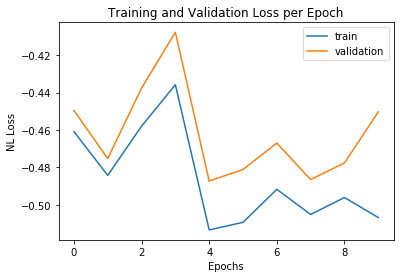

In [25]:

#plot logit loss
plt.plot(train_loss_history, label="train")
plt.plot( val_loss_history, label="validation")
plt.xlabel("Epochs")
plt.ylabel("NL Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend(loc="best")

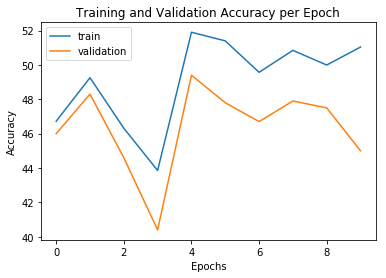

In [26]:
#plot logit accuracies
plt.plot(train_acc_history, label="train")
plt.plot(val_acc_history, label="validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy per Epoch")
plt.legend(loc="best")